# CS5014 Machine Learning 

##### Practical 1 
##### Credits: 50% of the coursework

##### Deadline: 12/03/2025


_Note that MMS is the definitive source for deadlines and weights._

## Aims


The objectives of this assignment are:

* deepen your understanding of linear regression and logistic regression
* gain experience in implementing learning algorithms 
* gain experience in evaluating machine learning algorithms


## Set-up

You are **only allowed** to use the following imported packages for this practical. No off-the-shelf machine learning packages such as _scikit-learn_ are allowed. 


In [1]:
# if you use jupyter-lab, switch to %matplotlib inline instead
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    
from autograd import hessian
import autograd.numpy.linalg as linalg
import matplotlib.pyplot as plt
import pandas as pd

The following method computes the gradient of a given function $f$ at an input location `initial`. Note that the finite difference method suffers from truncating and rounding errors and can be slow for large-scale machine learning models. It should never be directly used in a gradient descent algorithm. But it can be very useful to check your gradient derivation and implementation. You should always check your gradients before using them.

In [2]:
def finite_difference_gradient(f, initial, eps=1e-6):
    initial = np.array(initial, dtype=float)
    n = len(initial)
    output = np.zeros(n)
    for i in range(n):
        ei = np.zeros(n)
        ei[i] = 1
        f1 = f(initial + eps * ei)
        f2 = f(initial - eps * ei)
        output[i] = (f1-f2)/(2*eps)
    output = output.reshape(n,1)
    return output

## Question 1 (Lasso regression)


In this question, we are going to investigate Lasso regression. You are going to implement a gradient descent based learning algorithm for Lasso. Then use the implemented algorithm to find out what features are truely relevant in predicting the target. 

The dataset $\{\mathbf{x}^{(i)}, y^{(i)}\}$ is imported below for you:
* the input design matrix `d1X` contains ``n=200`` observations and each $\mathbf{x}^{(i)}$ has ``m=200`` features 
* and the last column is the regression targets ${y}^{(i)}$ (and they are stored in `d1Y`)
* among the 200 features, however, only three of them are relevant to the target $y$; and the rest 197 features are random noises
* you may assume the bias term is zero for this question



In [3]:
# read in dataset1
dataset1_df = pd.read_csv('dataset1.csv', header=0)
dataset1 = np.array(dataset1_df)
d1X, d1Y = dataset1[:, 0:200], dataset1[:, -1]

### Task 1.1


Recall that Lasso regression's loss function is defined as  


$$L(\mathbf{w}) = \frac{1}{2n} \sum_{i=1}^n (y^{(i)} - \mathbf{w}^{\top}\mathbf{x}^{(i)})^2 + \lambda \sum_{j=1}^m |w_j|,$$
where $\lambda >0$ is the penalty coefficient

* give the gradient expression for $\mathbf{w}$
* then implement a gradient descent based algorithm to learn the parameter

*Hint: To deal with sub-gradient descent properly, you may need to do the following: when the learning process is about to converge (e.g. after certain number of iterations)* 
1. *use a diminishing learning rate, e.g.* $\gamma_t = \frac{\gamma}{\sqrt{t}}$
2. *if any weight switches signs during the learning process, set the weight to zero directly*
3. *soft-thresholding, set a small constant e.g. $\epsilon = 10^{-5}$, if any weight's absolute value drops below $\epsilon$, set it to zero directly*;
*You can do either 2 or 3 (or both).*

In [4]:

dataset1df = pd.read_csv("dataset1.csv", header = 0)
dataset1 = np.array(dataset1df)
d1X, d1Y = dataset1[:, 0:200], dataset1[:,-1]

X = d1X
y = d1Y


def lassoLoss(X,y, w, lam):
    n = len(y)
    predictions = X @ w
    residuals = y - predictions 
    loss = (1/(2*n)) * np.sum(residuals ** 2 ) + lam * np.sum(np.abs(w))
    return loss


def lassoGradient(X,y,w, lam):
    n = len(y)
    predictions = X @ w
    gradient = -(1/n) * X.T @ (y - predictions) + lam * np.sign(w) # the gradient for lasso regression can be found here. 
    return gradient



def softThreshold(w, lam):
    return np.sign(w) * np.maximum(0, np.abs(w)- lam)



def lassoGradientDescent(X, y, w, lam, learningRate, iterations, epsilon=1e-5):
    
    for t in range(1,iterations + 1 ):
        learningRateT = learningRate / np.sqrt(t) # the diminshing learning rate

        gradientW = lassoGradient(X,y,w,lam)

        w -= learningRateT * gradientW 
        w = softThreshold(w, lam)  
       
        w[np.abs(w)< epsilon] = 0
    
    return w
    
wInt = np.zeros(X.shape[1])
lam = 0.001 
learningRate = 0.1
iterations = 1000

wHat = lassoGradientDescent(X, y, wInt, lam, learningRate, iterations)

relevantFeatures = np.where(wHat != 0)[0]

print("Estimated coefficients" , wHat)
print("Relevant Features: ", relevantFeatures)


Estimated coefficients [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.72237738 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.68936104 0.         0.         0.         0.
 0.         0.         0.        

### Task 1.2 

A special property of Lasso regression is sparsity. That means, if a proper penalty parameter is used, irrelevant input features' parameters will become zero. And this sparsity property can be used to find out which input features are important or relevant. In this task, you are going to use the algorithm implemented in Task 1.1 to investigate which three of the input dimensions are truly relevant in terms of predicting the targets $y$. 

* plot the full regularisation path of $\hat{\mathbf{w}}(\lambda)$ for a range of penalty parameter $\lambda$


* use the plot to tell which features are relevant and what are their cooresponding weights?

*Hint:*
1. *To find out the relevant features, you should try different $\lambda$s and find the whole regularisation path; $\ln\lambda \in [-8:0]$ seems appropriate*;
2. *It is a good idea to fit Lasso with $\lambda$s in an ascending order; since we know as $\lambda$ increases, more weight $\hat{\mathbf{w}}(\lambda_t)$ will become sparse*; 
3. *Instead of initialising the weight randomly for the gradient descent, you may "warm start" the algorithm with the learnt parameter with a smaller $\lambda$;*


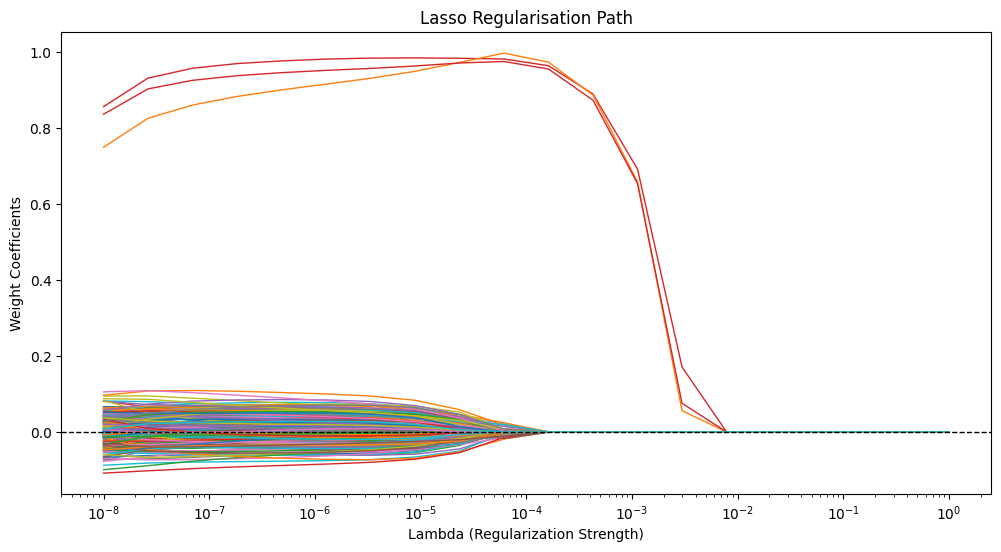

Estimated coefficients: [-2.24660350e-02 -3.38874433e-02 -4.52688936e-02  8.11415174e-02
  3.59394668e-02 -6.87556834e-02  4.71845435e-02 -3.46630020e-02
  5.68542619e-02  8.12823946e-02  8.02147275e-03 -4.42693731e-02
  2.34752342e-02  4.68007216e-02 -7.44566434e-02 -2.41799236e-02
 -5.16552971e-02 -7.33116487e-02 -7.95078083e-03  7.79129592e-03
 -4.97945181e-03  1.18229616e-02 -5.42943648e-03  3.05325120e-03
  1.66771030e-02 -2.78987905e-02  1.52895010e-02 -2.88672823e-02
 -1.11517165e-02 -8.12181899e-03  6.64314877e-02 -2.15972966e-02
  5.95601543e-02 -3.23269350e-02  6.38684141e-02  3.05917159e-02
 -2.47431286e-03  2.50331221e-02  1.84297943e-02  5.65855715e-02
  3.96140551e-02  4.52522656e-02  8.86880529e-03  8.55722437e-01
 -5.04901627e-02 -6.31483942e-03 -1.10309456e-02 -5.74192707e-03
  9.40618896e-02 -1.36628047e-02 -6.71081979e-02  9.62876002e-02
  5.45550293e-02  2.34503721e-02 -3.61742468e-02  4.10727333e-03
  7.68852626e-03  3.85382453e-02  3.91322800e-02 -5.48043495e-02
 

In [5]:
### report your results

dataset1df = pd.read_csv("dataset1.csv", header = 0)
dataset1 = np.array(dataset1df)
d1X, d1Y = dataset1[:, 0:200], dataset1[:,-1]

X = d1X
y = d1Y



def lassoLoss(X,y, w, lam):
    n = len(y)
    predictions = X @ w
    residuals = y - predictions 
    loss = (1/(2*n)) * np.sum(residuals ** 2 ) + lam * np.sum(np.abs(w))
    return loss


def lassoGradient(X,y,w, lam):
    n = len(y)
    predictions = X @ w
    gradient = -(1/n) * X.T @ (y - predictions) + lam * np.sign(w)
    return gradient



def softThreshold(w, lam):
    return np.sign(w) * np.maximum(0, np.abs(w)- lam)


def lassoGradientDescent(X, y, w, lam, learningRate, iterations, epsilon=1e-5):
    
    for t in range(1,iterations + 1 ):
        learningRateT = learningRate / np.sqrt(t) # the diminshing learning rate

        gradientW = lassoGradient(X,y,w,lam)

        w -= learningRateT * gradientW
        w = softThreshold(w, lam)
        w[np.abs(w)< epsilon] = 0
    
    return w

lamdaValue = np.logspace(-8,0,20)
wPath = []

    
wCurrent = np.zeros(X.shape[1])
learningRate = 0.1
iterations = 1000

for lam in lamdaValue: 
    wCurrent = lassoGradientDescent(X,y, wCurrent,lam,learningRate,iterations)
    wPath.append(wCurrent.copy())

wPath = np.array(wPath)
plt.figure(figsize=(12,6))
for i in range(X.shape[1]):
    plt.plot(lamdaValue,wPath[:,i], label = f'Feature {i}' if i<3 else "", lw=1)

plt.xscale("log")  # Log scale for lambda
plt.xlabel("Lambda (Regularization Strength)")
plt.ylabel("Weight Coefficients")
plt.title("Lasso Regularisation Path")
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.show()

# three most relevant features (highest absolute weights for small lambda)
wFinal = wPath[0]  # Smallest lambda value weights
relevantFeatures = np.argsort(np.abs(wFinal))[-3:]

print("Estimated coefficients:", wFinal)
print("Relevant Features:", relevantFeatures)


Report the findings: 
Lasso Regularisation with weight coefficients change the regularisation strength on a log scale. 
The graph plots regularisation strength against the weight coefficients. 

As lambda increases the coefficient of different feature coefficients shrink towards 0. 
By lambda = 10^ -2 almost all the coeffiecents are very close to 0

The features at the higher weight coefficients maintain high coefficient values as the lambda increases until around 10^-3 where they too begin to decline.

This graph demonstrates the selection capability of Lasso which forces most coefficeints to shrink to zero, which effectively remoces features from th emodel and maintain the non-zero coefficients which are indicative of the most important predictor features.

## Question 2 (Logistic regression)

In this question, we are going to implement a logistic regression model to do binary classification on a simulated dataset. The dataset's input feature are four-dimensional vectors $\mathbf{x}^{(i)} \in \mathbb{R}^4$ and as expected the targets are binary, *i.e.* $y^{(i)} \in \{0, 1\}$. 


The dataset $\{\mathbf{x}^{(i)}, y^{(i)}\}$ is imported below for you:
* ``dataset2``: 2000 observations and each input $\mathbf{x}$ has 4 features 
* and the last column is the target ${y}^{(i)}$
* the dataset is then split into training and testing parts

In [6]:
# read in dataset2
dataset2_df = pd.read_csv('dataset2.csv', header=0)
dataset2 = np.array(dataset2_df)
d2X, d2Y = dataset2[:, 0:4], dataset2[:, -1]
# split the data into training and testing 
# the training dataset has the first 1500 observation; 
# in practice, you should randomly shuffle before the split
d2_xtrain, d2_ytrain = d2X[0:1500, :], d2Y[0:1500]
# the testing dataset has the last 500
d2_xtest, d2_ytest = d2X[1500:, :], d2Y[1500:]

### Task 2.1 Implementation of logistic regression

Your task here is to implement a gradient descent based algorithm to train a logistic regression model. For this task, you cannot use `autograd`'s auto-differentiation method (*i.e.* the imported `grad` method). You will be guided to finish the task step by step. 

First, implement the `sigmoid` function:

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

In [7]:
def sigmoid(z):
    return  1/(1+np.exp(-z))

Second, implement the cross-entropy loss and its gradient. You may want to refer to the lecture slides for the details. Recall the binary **C**ross **E**ntropy (CE) _loss_ is 


$$
L(\mathbf{w}, b)=  -\frac{1}{n}\sum_{i=1}^n {y^{(i)}} \ln \sigma^{(i)}+ (1- y^{(i)}) \ln (1-\sigma^{(i)})
$$

where $\sigma^{(i)} =\sigma(\mathbf{w}^\top\mathbf{x}^{(i)} + b).$

In [8]:

def cross_entropy_loss_with_gradient(w,b,X,y):
     ## compute the loss 
   
    n = X.shape[0]

    z = X @ w + b
    yPred = sigmoid(z)
    yPred = yPred.reshape(-1)

    loss = -np.mean(y* np.log(yPred + 1e-5) + ( 1- y) * np.log(1- yPred + 1e-8))

## compute the gradient w.r.t w and b
    error = yPred - y
    gradW = (1/n) * (X.T @ error)
    gradB = (1/n) * np.sum(error)

    return loss, gradW, gradB

Now, implement the gradient descent algorithm below. Before that, you should consider testing our gradient implementation before using it in the training algorithm. 

In [9]:

def logistic_regression_train(X, y, lr = 0.1, tol= 1e-5, maxIters= 2000):
    
    n, d = X.shape 
    w0 = np.zeros(d)
    b0 = 0.0

    losses = []
    # loop until converge
    for i in range(maxIters):
        ## Implement gradient descent here
        loss, gradW, gradB = cross_entropy_loss_with_gradient(w0,b0,X,y)
        losses.append(loss)

        w0 -= lr * gradW
        b0 -= lr * gradB

        if i > 1 and abs(losses[-1] - losses[-2])< tol:
            print(f"Converged at iteration {i}")
            break
            
    return w0, b0, losses



After you finish implementing all the above methods, use your learning algorithm to train a logistic regression model on the training dataset and answer the following questions:

* plot the learning curve
* report the learnt parameter with a learning rate 0.1, `tol=1e-5` and `maxIters=2000`
* report the classification accuracy on the test dataset

Converged at iteration 1010
Final Weights: [ 5.99479266e-01 -7.16446267e-01  3.37897248e+00 -3.27575576e-03]
Final Bias:  -1.9552222629411453


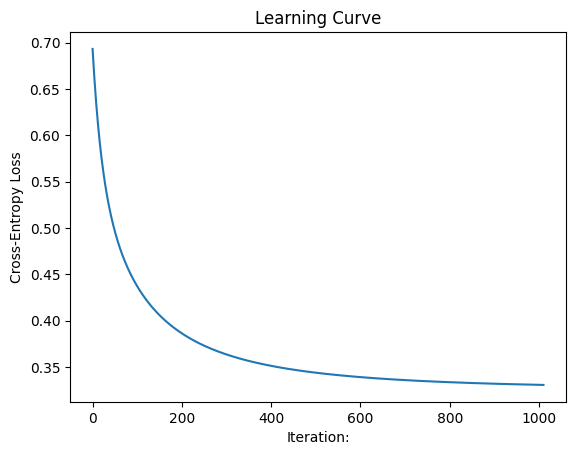

Test Accuracy: 83.40%


In [10]:
## run your algorithm and report your findings
wFinal, bFinal, lossHistory = logistic_regression_train(d2_xtrain, d2_ytrain, lr=0.1)

print("Final Weights:" , wFinal)
print("Final Bias: ", bFinal)


plt.plot(lossHistory)
plt.xlabel("Iteration:")
plt.ylabel("Cross-Entropy Loss")
plt.title("Learning Curve")
plt.show()

def predict(X,w,b):
    probabilities = sigmoid(X @ w+b)
    return (probabilities >=0.5).astype(int)

yPredTest = predict(d2_xtest, wFinal, bFinal)
accuracy = np.mean(yPredTest == d2_ytest)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


### Task 2.2 Regularisation

In this sub-task, you are going to apply $L_2$ regularisation to the logistic regression model. The regularised loss is

$$
L(\mathbf{w}, b)= - \frac{1}{n}\sum_{i=1}^n {y^{(i)}} \ln \sigma^{(i)}+ (1- y^{(i)}) \ln (1-\sigma^{(i)}) + \frac{\lambda}{2} \|\mathbf{w}\|_2^2
$$

* where $\lambda >0$ is the regularisation hyperparameter

* note that we do not usually apply penalty on the bias parameter $b$

Implement the following method that fits a regularised logistic regression model with a given $\lambda$.

Converged at iteration 1010
Converged at iteration 588


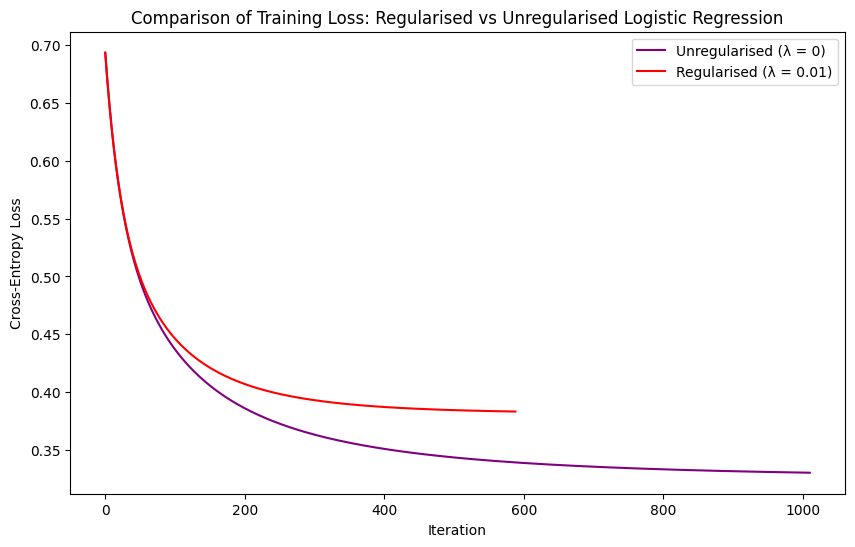

Test Accuracy (Unregularised): 83.40%
Test Accuracy (Regularised): 82.80%


In [11]:
def cross_entropy_loss_with_gradient(w0, b0, X, y, lam):
    n = X.shape[0]

    z = X @ w0 + b0
    yPred = sigmoid(z)
    yPred = yPred.reshape(-1)

    #  cross-entropy loss with L2 penalty
    loss = -np.mean(y * np.log(yPred + 1e-8) + (1 - y) * np.log(1 - yPred + 1e-8)) + (lam / 2) * np.sum(w0 ** 2)

    # gradients
    error = yPred - y
    gradW0 = (1/n) * (X.T @ error) + lam * w0  
    gradB0 = (1/n) * np.sum(error)   

    return loss, gradW0, gradB0


def logistic_regression_reg_train(X, y, lr=0.1, lam=0.01, tol=1e-5, maxIters=2000): # function defines the logistic regression with regularisation
    n, d = X.shape
    w0 = np.zeros(d)  
    b0 = 0.0  
    losses = []

    
    for i in range(maxIters):
        loss, gradW0, gradB0 = cross_entropy_loss_with_gradient(w0, b0, X, y, lam)
        losses.append(loss)

        
        w0 -= lr * gradW0
        b0 -= lr * gradB0

        
        if i > 1 and abs(losses[-1] - losses[-2]) < tol:
            print(f"Converged at iteration {i}")
            break

    return w0, b0, losses


def logistic_regression_train(X, y, lr=0.1, tol=1e-5, maxIters=2000):
    n, d = X.shape
    w0 = np.zeros(d)  
    b0 = 0.0  
    losses = []

    
    for i in range(maxIters):
        z = X @ w0 + b0
        yPred = sigmoid(z)
        yPred = yPred.reshape(-1)

        
        loss = -np.mean(y * np.log(yPred + 1e-8) + (1 - y) * np.log(1 - yPred + 1e-8)) # loss function
        losses.append(loss)

        
        error = yPred - y # defines the error and the gradient
        gradW0 = (1/n) * (X.T @ error)
        gradB0 = (1/n) * np.sum(error)

        
        w0 -= lr * gradW0
        b0 -= lr * gradB0

    
        if i > 1 and abs(losses[-1] - losses[-2]) < tol:
            print(f"Converged at iteration {i}")
            break

    return w0, b0, losses


w0Unreg, b0Unreg, lossHistoryUnreg = logistic_regression_train(d2_xtrain, d2_ytrain, lr=0.1)


w0Reg, b0Reg, lossHistoryReg = logistic_regression_reg_train(d2_xtrain, d2_ytrain, lr=0.1, lam=0.01)


plt.figure(figsize=(10, 6))
plt.plot(lossHistoryUnreg, label='Unregularised (λ = 0)', color='purple')
plt.plot(lossHistoryReg, label='Regularised (λ = 0.01)', color='red')
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Comparison of Training Loss: Regularised vs Unregularised Logistic Regression")
plt.legend()
plt.show()


def predict(X, w0, b0):
    probabilities = sigmoid(X @ w0 + b0)
    return (probabilities >= 0.5).astype(int)


yPredTestUnreg = predict(d2_xtest, w0Unreg, b0Unreg)
accuracyUnreg = np.mean(yPredTestUnreg == d2_ytest)

yPredTestReg = predict(d2_xtest, w0Reg, b0Reg)
accuracyReg = np.mean(yPredTestReg == d2_ytest)


print(f"Test Accuracy (Unregularised): {accuracyUnreg * 100:.2f}%")
print(f"Test Accuracy (Regularised): {accuracyReg * 100:.2f}%")


Complete and report the following two results
* report the training loss and learnt parameter by setting $\lambda=0.01$
* report the testing performance for the regularised logistic regression model with $\lambda=0.01$


Report your Findings: 

The graph above plots a comparison of regularised and unregularised logistic regression. The test accuracy of regularised regression drops from 83.40% to 82.80%. While there is a drop off in accuracy it is minimal. 
The main difference appears when with the number of iterations it takes to converge. The difference being 422 iterations. This suggests that the regaularised model accepts a higher training loss for better generalisation. The regularisation penalty prevents it from fitting perfectly on the training data.

### Task 2.3 Newton's method (extension)

For convex loss functions, Newton's method converges much faster than a simple gradient descent algorithm. Implement a learning algorithm for the regularised logsitic regression with Newton's method. You are allowed to use auto-diff to finish this task.


* use Newton's method to find the same logistic regression model

* compare with gradient descent's learning curve, what do you observe?

Newton's method converged at iteration 4
Converged at iteration 588


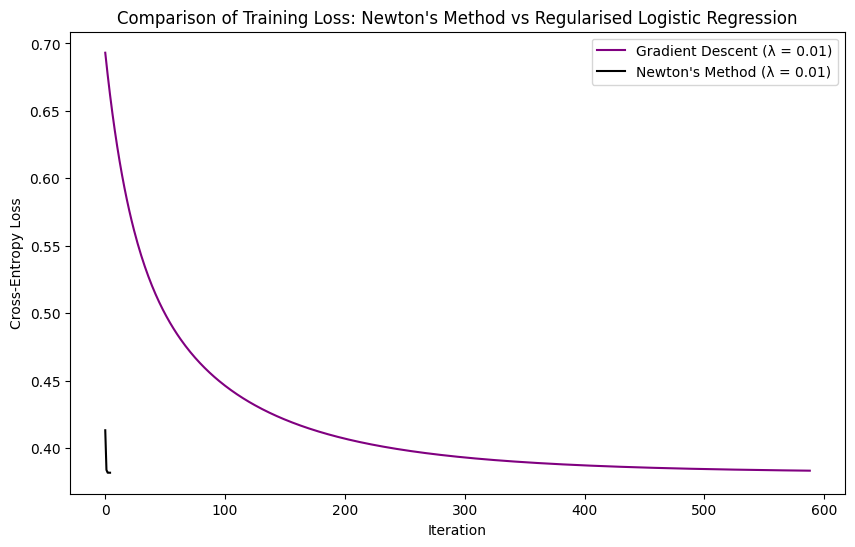

Test Accuracy Gradient Descent: 82.80%
Test Accuracy Newton's Method: 82.60%


In [12]:
## run Newton's method 
def lossFunction(wb,X,y, lam):
    w = wb[:-1]
    b = wb[-1]

    z = X @ w + b
    yPred = sigmoid(z)

    loss = -np.mean(y * np.log(yPred + 1e-8) + (1-y) * np.log(1 - yPred + 1e-8)) + (lam/2) * np.sum(w**2)
    return loss



def makelossWrapper(X,y, lam):
   return lambda wb: lossFunction(wb, X,y, lam)


def logistic_regression_newton(X,y, lam = 0.01, tol=1e-5, maxIters = 100):
    n,d = X.shape
    wb = np.zeros(d+1)
    losses = []

    lossWrapper = makelossWrapper(X,y, lam)
    gradLoss = grad(lossWrapper)
    hessianLoss = hessian(lossWrapper) # 2nd derivative 


    for i in range(maxIters): 

        gradwb = gradLoss(wb)
        hesswb = hessianLoss(wb)

        try:
           update = np.linalg.solve(hesswb, -gradwb)
        except np.linalg.LinAlgError:
           update = np.linalg.pinv(hesswb) @ -gradwb


        wb += update
        loss = lossWrapper(wb)
        losses.append(loss)


        if i > 1 and abs(losses[-1] - losses[-2]) < tol:
            print(f"Newton's method converged at iteration {i}")
            break

    return wb[:-1] , wb[-1], losses 


newtonw0 , newtonb0 , lossHistoryNewton = logistic_regression_newton(d2_xtrain, d2_ytrain, lam = 0.01) # trains the newton method 

gdw0, gdb0 , lossHistoryGD = logistic_regression_reg_train(d2_xtrain, d2_ytrain, lr = 0.1, lam=0.01) # trains the logistic regression for the purpose of comparison 

plt.figure(figsize=(10, 6))
plt.plot(lossHistoryGD, label='Gradient Descent (λ = 0.01)', color='purple')
plt.plot(lossHistoryNewton, label="Newton's Method (λ = 0.01)", color='black')
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Comparison of Training Loss: Newton's Method vs Regularised Logistic Regression")
plt.legend()
plt.show()


def predict(X, w0, b0):
    probabilities = sigmoid(X @ w0 + b0)
    return(probabilities >= 0.5).astype(int)

yPredTestNewton = predict(d2_xtest, newtonw0, newtonb0)
accuracyNewton = np.mean(yPredTestNewton == d2_ytest)


yPredTestgd = predict(d2_xtest, gdw0, gdb0)
accuracygd = np.mean(yPredTestgd == d2_ytest)

print(f"Test Accuracy Gradient Descent: {accuracygd *100:.2f}%")
print(f"Test Accuracy Newton's Method: {accuracyNewton *100:.2f}%")


Text(0, 0.5, 'Cross-Entropy Loss')

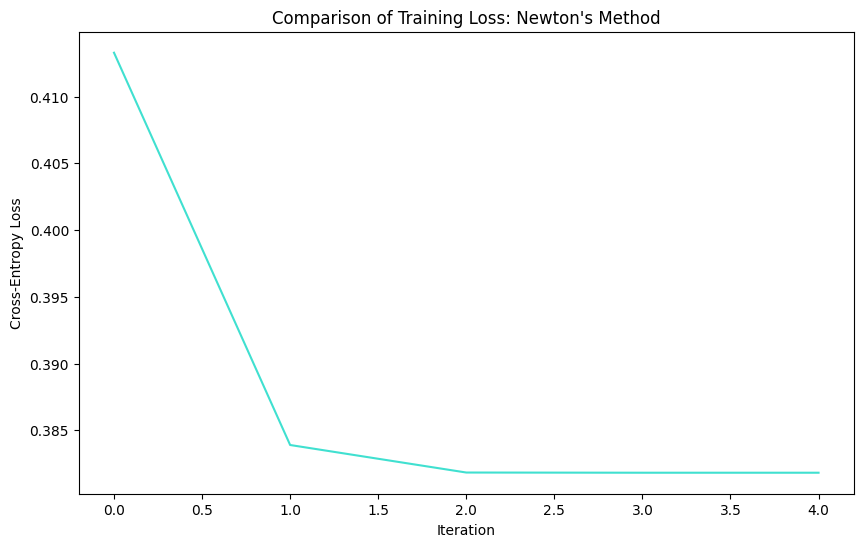

In [13]:
# Report your findings 
plt.figure(figsize=(10, 6))
plt.title("Comparison of Training Loss: Newton's Method")
plt.plot(lossHistoryNewton, color='turquoise')
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")

Report Findings: 
Newton's method converged at a much quicker rate over gradient descent taking only 4 iterations to converge as opposed to the regularised logistic regression which takes 588 iterations. The accuracy however falls by 0.20%. While this accuracy drop is minimal. Newton's method converges much quicker due to second order optimisation. By taking the hessian to determine the step direction and size. This gives it more precise information about the loss function. Newton's method is able to converge much quicker

### Task 2.4 Weighted logistic regression (extension)

Weighted logistic regression is a variant of the traditional logistic regression. It is usually used when the classification dataset is imbalanced. By assigning higher weights to the minority class and lower weights to the majority class, the model is encouraged to pay more attention to the minority class.

Specifically, each training instance $y^{(i)}$ is given a positive weight $r^{(i)}$, and the weighted cross entropy loss becomes 

$$L(\mathbf{w}, b) = - \frac{1}{\sum_{i=1}^n r^{(i)}} \sum_{i=1}^n r^{(i)}\cdot \left ( {y^{(i)}} \ln \sigma^{(i)}+ (1- y^{(i)}) \ln (1-\sigma^{(i)}) \right ) + \frac{\lambda}{2} \|\mathbf{w}\|_2^2$$

We can for example use the relative frequency of the training data to set $r^{(i)}$. Let $n^+ = \sum_{i=1}^n y^{(i)}$ and $n^- = n - n^+$ be the number of positive and negative training instances respectively in the training data. The weights can be set as 

$$r^{(i)} = \begin{cases}\frac{n}{n^-} & y^{(i)} = 0 \\ \frac{n}{n^+} & y^{(i)} =1\end{cases}$$



* derive and write down the gradient of the weighted loss w.r.t the learning parameter

* implement a suitable training algorithm to learn the parameter

* report the learnt parameter with $\lambda =0.1$

Weighted Logistic Regression Converged in 650 iterations.
Newton's method converged at iteration 2
Converged at iteration 203
Training Accuracy of Weighted Logistic Regression: 81.20%


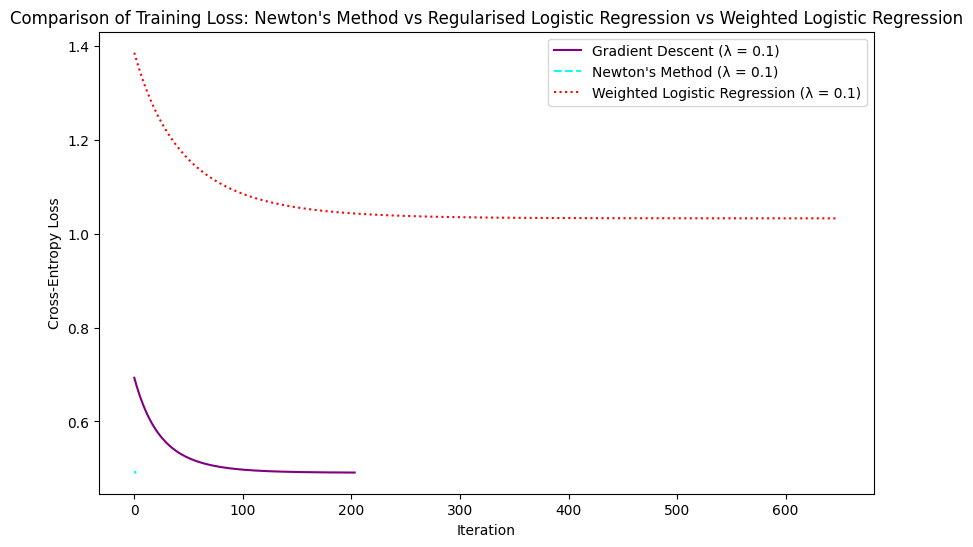

Learned parameters for Weighted Logistic Regression: [ 0.18139401 -0.2107177   1.09608212 -0.00918787] -0.2655607354504418


In [14]:
## gradient expression here

# computeWeights is to add the weights to the regression model to match the formula r(i)
def computeWeights(y):
    n = len(y)
    nPos = np.sum(y==1)
    nNeg = n - nPos
    weights = np.where(y==1, n/ nPos, n/nNeg)
    return weights

def weightedLogisticRegression(X, y, lam, lr, maxIters=2000, tol=1e-5):
    n, d = X.shape
    w0 = np.zeros(d)
    b0 = 0
    losses = []
    weights = computeWeights(y)
    weightSum = np.sum(weights)

    for i in range(maxIters):
        z = X @ w0 + b0
        yPred = sigmoid(z)

        gradW = (1/weightSum) * np.sum(weights[:, None] * (yPred - y)[:, None] * X, axis=0) + lam * w0
        gradB = (1/weightSum) * np.sum(weights * (yPred - y))

        w0 -= lr * gradW
        b0 -= lr * gradB

        
        loss = -np.mean(weights * (y * np.log(yPred) + (1 - y) * np.log(1 - yPred)))
        losses.append(loss)

        
        if np.linalg.norm(gradW) < tol and abs(gradB) < tol:
            print(f"Weighted Logistic Regression Converged in {i+1} iterations.")
            break

    return w0, b0, losses

weightedW0, weightedB0, lossHistoryWeighted = weightedLogisticRegression(d2_xtrain, d2_ytrain, lam=0.1, lr=0.1)
newtonw0 , newtonb0 , lossHistoryNewton = logistic_regression_newton(d2_xtrain, d2_ytrain, lam = 0.1) # trains the newton method 

gdw0, gdb0 , lossHistoryGD = logistic_regression_reg_train(d2_xtrain, d2_ytrain, lr = 0.1, lam=0.1) # trains the logistic regression for the purpose of comparison 


def accuracy(X, y, w0, b0):
    predictions = predict(X, w0, b0)
    return np.mean(predictions == y)


trainAccuracy = accuracy(d2_xtrain, d2_ytrain, weightedW0, weightedB0)
print(f"Training Accuracy of Weighted Logistic Regression: {trainAccuracy * 100:.2f}%")


plt.figure(figsize=(10, 6))
plt.plot(lossHistoryGD, label='Gradient Descent (λ = 0.1)', color='purple')
plt.plot(lossHistoryNewton, label="Newton's Method (λ = 0.1)", color='cyan', linestyle='dashed')
plt.plot(lossHistoryWeighted, label="Weighted Logistic Regression (λ = 0.1)", color='red', linestyle='dotted')
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Comparison of Training Loss: Newton's Method vs Regularised Logistic Regression vs Weighted Logistic Regression")
plt.legend()
plt.show()


print("Learned parameters for Weighted Logistic Regression:", weightedW0, weightedB0)

Text(0, 0.5, 'Cross-Entropy Loss')

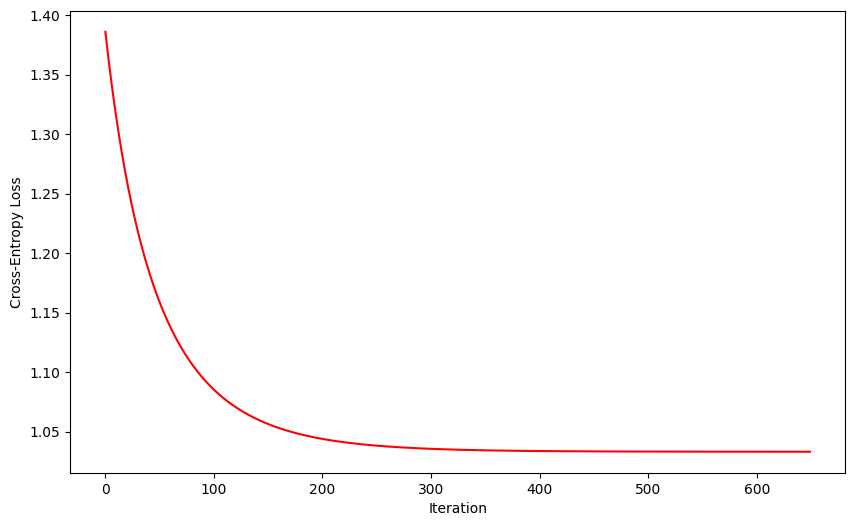

In [15]:
## Implement and run your algorithm and report your findings
plt.figure(figsize=(10, 6))
plt.plot(lossHistoryWeighted, label="Weighted Logistic Regression (λ = 0.1)", color='red')
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")


To derive the gradient for this function it can be done by using calculs if given the loss function.  First differentiate the sigmoid function. 

This becomes: sigmoid output multiplied by one minus the sigmoid output.

Derivative of the loss function: 
Applying Chain rule and simplifying the gradient can be: 

For each training example:
Compute the predicted probability using the sigmoid function.
Subtract the true label from the predicted probability.
Multiply this difference by the weight of the example.
Multiply the result by the feature values of the example. 
​
​The gradient of the weighted logistic regression loss is the sum, over all training examples, of:

The weight assigned to the example multiplied by
(the predicted probability minus the actual label) multiplied by
the feature values of the example.
 




Report your findings: 
This graph suggests that Newton's method is still the quickest to converge in comparison to other methods. Taking only 2 iterations to converge 

The logistic regression with a regularised penalty has a more gradual convergence while also starting at a higher loss than Newton method.The more gradual convergence starts at a loss of around 0.7 and then gradually levels out arond 0.5. It is able to converge at around 200 iterations.

Finally the weighted logistic regression line has the highest starting loss of around 1.4 and also takes longer to converge around 650 iterations it begins to plateau around a loss of 1.0 

Weighted Regression performs the worst of the three methods in both the accuracy (81.20%) the loss and convergence compared to the others. This suggests that it factors in additional considerations which affect the rate at which it converges. 

## Submission
Hand in via MMS: the completed jupyter notebook. Your notebook should be reproducible. 



## Marking
Your submission will be marked as a whole. 

* to get a grade above 7, you are expected to finish at least Task 1.1 to a good standard
* to get a grade above 10 and up to 13, you are expected to complete Task 1.1-1.2 and Task 2.1 to a good standard
* to get a grade above 13 and up to 17, you are expected to complete all tasks except 2.3 and 2.4 a good standard
* to achieve a grade of 17+, you are expected to finish all tasks well
* to get 18+, you are expected to attempt all questions flawlessly


## Policies

* See the Generic Mark Descriptors in the School Student Handbook: 

  [http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#Mark_Descriptors](http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/feedback.html#Mark_Descriptors)


* The standard penalty for late submission applies (Scheme A: 1 mark per 24 hour period, or part thereof):
  
  [http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/assessment.html#lateness-penalties](http://info.cs.st-andrews.ac.uk/student-handbook/learning-teaching/assessment.html#lateness-penalties)


* The University policy on Good Academic Practice applies:

  [https://www.st-andrews.ac.uk/students/rules/academicpractice/](https://www.st-andrews.ac.uk/students/rules/academicpractice/)